In [1]:
import pandas as pd

# Load the Excel file into a DataFrame
data = pd.read_excel('C:/Users/mesic/OneDrive - The Conference Board of Canada\Python\CAHRC\Interview_summary_matrix.xlsx')

In [6]:
# Clean and tokenize data #

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define column names
column_names = [
    'Q1_a', 'Q1_b', 'Q1_c',
    'Q2_a', 'Q2_b', 'Q2_c',
    'Q3_a', 'Q3_b', 'Q3_c', 'Q3_d',
    'Q4_a', 'Q4_b', 'Q4_c', 'Q4_d',
    'Q5', 'Q5_a', 'Q5_b', 'Q5_c',
    'Q6_a', 'Q6_b', 'Q6_c', 'Q6_d', 'Q6_e',
    'Q7',
    'Q8_a', 'Q8_b',
    'Q9','Q9_a', 'Q9_b', 'Q9_c', 'Q9_d', 'Q9_e', 'Q9_f'
]

# Create a new DataFrame for cleaned text and tokens
cleaned_data = pd.DataFrame()

# Combine all responses into a single column
responses = []
for col_name in column_names:
    responses.extend(data[col_name].dropna().tolist())

# Preprocess the text
cleaned_text = [response.replace('[^\w\s]', '').lower() for response in responses]
tokens = [word_tokenize(text) for text in cleaned_text]
stop_words = set(stopwords.words('english'))
tokens = [[word for word in token_list if word not in stop_words] for token_list in tokens]
lemmatizer = WordNetLemmatizer()
tokens = [[lemmatizer.lemmatize(word) for word in token_list] for token_list in tokens]

# Update the cleaned_data DataFrame with the preprocessed text
cleaned_data['cleaned_text'] = cleaned_text
cleaned_data['tokens'] = tokens

# Reset the index of the original DataFrame
data.reset_index(drop=True, inplace=True)

# Merge the cleaned_data DataFrame with the original DataFrame
merged_data = pd.concat([data, cleaned_data], axis=1)

# Now you can use merged_data for further analysis


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mesic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mesic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mesic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


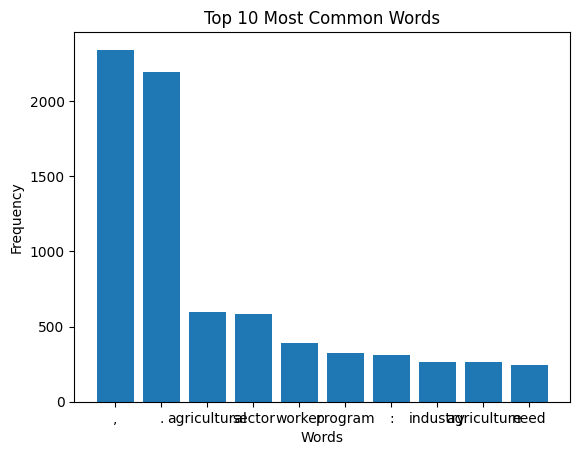

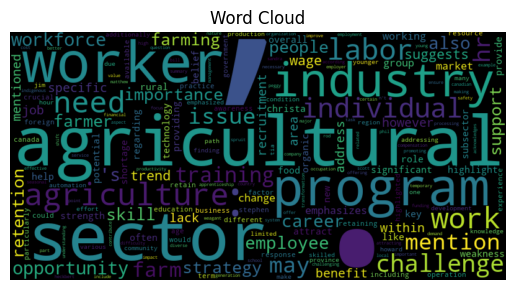

In [12]:
### Word Frequency Analysis ###

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Calculate word frequencies
word_freq = Counter(token for sublist in merged_data['tokens'] for token in sublist)

# Get the most common words
top_words = word_freq.most_common(10)

# Plot word frequencies
plt.bar(*zip(*top_words))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.show()

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


In [13]:
### Sentiment Analysis ###

import nltk

nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Perform sentiment analysis
sentiment_scores = [sia.polarity_scores(text)['compound'] for text in merged_data['cleaned_text']]

# Add sentiment scores to the merged_data DataFrame
merged_data['sentiment_score'] = sentiment_scores

# Calculate the overall sentiment distribution
sentiment_distribution = merged_data['sentiment_score'].value_counts(normalize=True)
print(sentiment_distribution)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mesic\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment_score
0.4404    0.017632
0.0000    0.012594
0.9118    0.010076
0.5859    0.010076
0.7003    0.010076
            ...   
0.8445    0.002519
0.7425    0.002519
0.6705    0.002519
0.1508    0.002519
0.9422    0.002519
Name: proportion, Length: 298, dtype: float64


In [5]:
### Topic Modelling  ###

import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# List of column names with preprocessed text
columns = ['Q1_a', 'Q1_b', 'Q1_c', 'Q2_a', 'Q2_b', 'Q2_c', 'Q3_a', 'Q3_b', 'Q3_c', 'Q3_d', 'Q4_a', 'Q4_b', 'Q4_c', 'Q4_d', 'Q5', 'Q5_a', 'Q5_b', 'Q5_c', 'Q6_a', 'Q6_b', 'Q6_c', 'Q6_d', 'Q6_e', 'Q7', 'Q8_a', 'Q8_b', 'Q9', 'Q9_a', 'Q9_b', 'Q9_c', 'Q9_d', 'Q9_e', 'Q9_f']

for column in columns:
    # Replace np.nan values with empty strings
    data[column].fillna('', inplace=True)

    # Create a document-term matrix
    vectorizer = CountVectorizer()
    dtm = vectorizer.fit_transform(data[column])

    # Initialize the LDA model
    lda_model = LatentDirichletAllocation(n_components=5, random_state=42)

    # Fit the LDA model to the document-term matrix
    lda_model.fit(dtm)

    # Extract the most important words for each topic
    feature_names = np.array(list(vectorizer.vocabulary_.keys()))
    topics = []
    for idx, topic in enumerate(lda_model.components_):
        topic_words = feature_names[np.argsort(topic)][:-10-1:-1]
        topics.append(topic_words)

    # Print the topics for the current column
    print(f"Topics for column '{column}':")
    for idx, topic_words in enumerate(topics):
        print(f"Topic {idx + 1}: {', '.join(topic_words)}")
    print('\n')


Topics for column 'Q1_a':
Topic 1: compromise, hiring, enter, down, number, existing, start, agriculture, manufacturing, poultry
Topic 2: compromise, while, existing, enter, start, down, disagreed, number, investments, packages
Topic 3: compromise, down, enter, existing, poultry, below, number, products, older, hiring
Topic 4: ensure, consideration, companies, those, to, plays, generation, problem, inability, through
Topic 5: ensure, consideration, companies, those, to, plays, generation, problem, inability, through


Topics for column 'Q1_b':
Topic 1: within, many, machinery, market, harvesting, one, are, associated, has, work
Topic 2: within, many, machinery, market, harvesting, one, are, associated, has, work
Topic 3: within, many, machinery, market, harvesting, one, are, associated, has, work
Topic 4: faces, choose, packaging, employees, which, rural, overall, next, success, the
Topic 5: within, many, machinery, market, harvesting, one, are, associated, has, work


Topics for colum

Topics for column 'Q5_b':
Topic 1: over, don, with, cyr, sync, variations, goals, increasing, prominence, identify
Topic 2: make, identify, effectiveness, sized, skills, the, return, sector, decreasing, initiatives
Topic 3: cyr, sync, variations, areas, limited, often, with, acknowledged, goals, importance
Topic 4: awareness, with, cyr, over, variations, train, sync, often, limited, might
Topic 5: cyr, with, awareness, variations, sync, over, overhaul, often, due, personnel


Topics for column 'Q5_c':
Topic 1: dedicated, burden, summary, response, having, already, underrepresented, favorable, actively, while
Topic 2: staff, transformations, response, subsector, available, would, colleges, including, seeking, farm
Topic 3: dedicated, countries, having, response, barriers, he, different, fail, ensure, christa
Topic 4: jim, barriers, feasibility, policymakers, retention, faced, depends, hiring, gap, conclusion
Topic 5: dedicated, response, burden, underrepresented, summary, already, havin